# Handwritten Digit Recognition using Neural Networks

### Overview

In this project, we will train a neural network on the MNIST dataset to identify handwritten digits. 

### Importing and splitting the dataset
in the following cell, we will import the dataset and split it into training, testing and validation datasets



In [114]:
# from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import random
import idx2numpy
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [115]:
# Paths to MNIST files
train_images_path = './data/MNIST/raw/train-images-idx3-ubyte'
train_labels_path = './data/MNIST/raw/train-labels-idx1-ubyte'
test_images_path = './data/MNIST/raw/t10k-images-idx3-ubyte'
test_labels_path = './data/MNIST/raw/t10k-labels-idx1-ubyte'
# Function to load IDX file into a NumPy array
def load_idx_file(file_path):
    return idx2numpy.convert_from_file(file_path)
# Load the data
train_images = load_idx_file(train_images_path)
train_labels = load_idx_file(train_labels_path)
test_images = load_idx_file(test_images_path)
test_labels = load_idx_file(test_labels_path)
# Combine training and testing data
images = np.concatenate([train_images, test_images], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)
# Normalize images (scale pixel values to [0, 1])
images = images.astype(np.float32) / 255.0
# Shuffle the data
indices = np.arange(len(labels))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]
# Split the data: Train (50,000), Validation (10,000), Test (10,000)
train_images, val_images, test_images = np.split(images, [50000, 60000])
train_labels, val_labels, test_labels = np.split(labels, [50000, 60000])
# Convert images and labels to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
# Flatten images to (batch_size, 28*28)
train_images_tensor = train_images_tensor.view(-1, 28*28)
val_images_tensor = val_images_tensor.view(-1, 28*28)
test_images_tensor = test_images_tensor.view(-1, 28*28)

# Create TensorDataset and DataLoader for training, validation, and test sets
batch_size = 64
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([64, 784]) torch.Size([64])


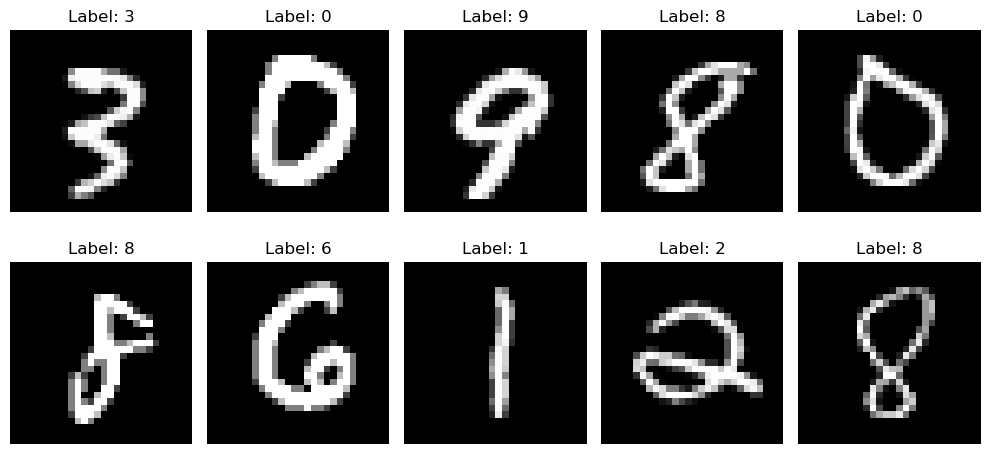

In [116]:
# Get a batch of training data
examples = iter(train_loader)
samples, labels = next(examples)  # Use next() to get the next batch

# Print the shape of the sample and labels (Optional, for debugging)
print(samples.shape, labels.shape)

# Create a 2x5 grid to display 10 images
plt.figure(figsize=(10, 5))  # Set the size of the figure

# Loop through the first 10 samples and plot them
for i in range(10):  
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns, index starts from 1
    # Reshape the image to 28x28 and display it
    plt.imshow(samples[i].view(28, 28).cpu().numpy(), cmap='gray')  # Convert tensor to NumPy array for plotting
    plt.title(f"Label: {labels[i].item()}")  # Display the corresponding label
    plt.axis('off')  # Hide the axes for a cleaner look

# Show the plot
plt.tight_layout()
plt.show()


### Training
In the following cell we will import the Neural network module and initialize it

#### Bonus

In [117]:
class CNN(nn.Module):
    def __init__(self, layer_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.layers = nn.ModuleList()
        for i in range(len(layer_size)-1):
            self.layers.append(nn.Linear(layer_size[i], layer_size[i+1]))

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))
            x = self.dropout(x)
        x = self.layers[-1](x)
        return x


#### model

In [118]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Create layers dynamically
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))  # Apply ReLU to all but the last layer
        x = self.layers[-1](x)  # Last layer without ReLU
        return x

In [119]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    TrainLoss = []
    ValLoss = []
    TrainAcc = []
    ValAcc = []
    for epoch in range(epochs):
        train_loss = 0
        train_correct = 0
        total_train = 0
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * train_correct / total_train
        TrainAcc.append(train_accuracy)

        val_loss = 0
        val_correct = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / total_val
        ValAcc.append(val_accuracy)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        TrainLoss.append(train_loss/len(train_loader))
        ValLoss.append(val_loss/len(val_loader))
        
    return TrainLoss, ValLoss, TrainAcc, ValAcc

# Epochs = 10
# epochs = range(1, Epochs+1)
# train_losses, val_losses, train_accuracies, val_accuracies_lr = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=Epochs)


In [120]:
def plot(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    # Create a single figure
    plt.figure(figsize=(10, 4))  

    # Plot Training and Validation Loss in the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    # Plot Training and Validation Accuracy in the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the figure
    plt.show()


#### Try diff values

Testing different layer configurations

Training with layer configuration: [784, 128, 64, 10]
Epoch 1, Train Loss: 1.8528, Val Loss: 1.0210, Train Acc: 44.90%, Val Acc: 78.17%
Epoch 2, Train Loss: 0.6725, Val Loss: 0.4972, Train Acc: 83.26%, Val Acc: 86.49%
Epoch 3, Train Loss: 0.4412, Val Loss: 0.3943, Train Acc: 87.90%, Val Acc: 88.82%
Epoch 4, Train Loss: 0.3748, Val Loss: 0.3549, Train Acc: 89.45%, Val Acc: 89.79%
Epoch 5, Train Loss: 0.3394, Val Loss: 0.3293, Train Acc: 90.39%, Val Acc: 90.50%
Epoch 6, Train Loss: 0.3157, Val Loss: 0.3103, Train Acc: 90.94%, Val Acc: 91.26%
Epoch 7, Train Loss: 0.2963, Val Loss: 0.2998, Train Acc: 91.53%, Val Acc: 91.56%
Epoch 8, Train Loss: 0.2794, Val Loss: 0.2828, Train Acc: 92.05%, Val Acc: 92.01%
Epoch 9, Train Loss: 0.2648, Val Loss: 0.2723, Train Acc: 92.46%, Val Acc: 92.21%
Epoch 10, Train Loss: 0.2512, Val Loss: 0.2573, Train Acc: 92.82%, Val Acc: 92.70%
Epoch 11, Train Loss: 0.2386, Val Loss: 0.2496, Train Acc: 93.19%, Val Acc: 92.93%
Ep

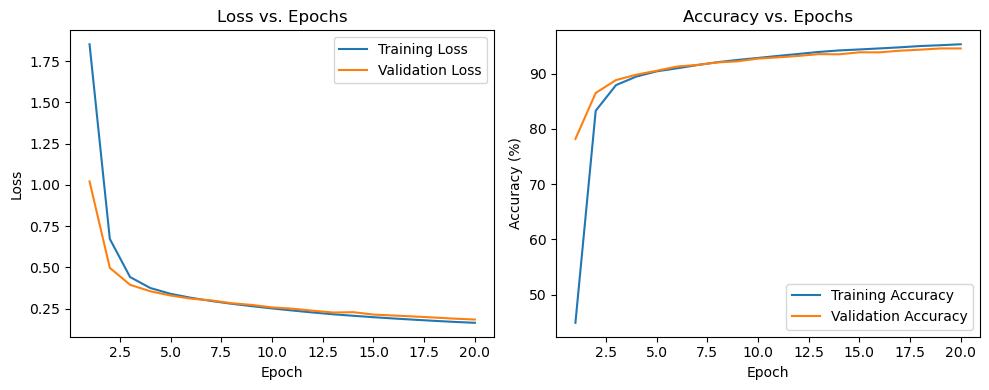

Training with layer configuration: [784, 128, 64, 32, 10]
Epoch 1, Train Loss: 2.2454, Val Loss: 2.0935, Train Acc: 20.67%, Val Acc: 26.36%
Epoch 2, Train Loss: 1.5240, Val Loss: 0.9632, Train Acc: 49.32%, Val Acc: 72.83%
Epoch 3, Train Loss: 0.6896, Val Loss: 0.5217, Train Acc: 80.32%, Val Acc: 84.62%
Epoch 4, Train Loss: 0.4680, Val Loss: 0.4223, Train Acc: 86.73%, Val Acc: 88.08%
Epoch 5, Train Loss: 0.3951, Val Loss: 0.3661, Train Acc: 88.84%, Val Acc: 89.73%
Epoch 6, Train Loss: 0.3484, Val Loss: 0.3322, Train Acc: 90.18%, Val Acc: 90.55%
Epoch 7, Train Loss: 0.3161, Val Loss: 0.3043, Train Acc: 91.07%, Val Acc: 91.39%
Epoch 8, Train Loss: 0.2896, Val Loss: 0.2979, Train Acc: 91.87%, Val Acc: 91.41%
Epoch 9, Train Loss: 0.2665, Val Loss: 0.2664, Train Acc: 92.42%, Val Acc: 92.53%
Epoch 10, Train Loss: 0.2446, Val Loss: 0.2463, Train Acc: 93.08%, Val Acc: 92.97%
Epoch 11, Train Loss: 0.2247, Val Loss: 0.2296, Train Acc: 93.62%, Val Acc: 93.39%
Epoch 12, Train Loss: 0.2069, Val Loss

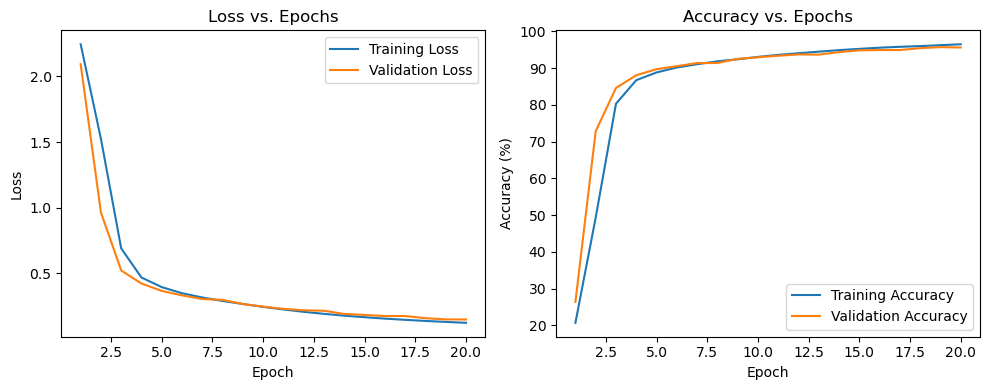

Training with layer configuration: [784, 256, 128, 64, 32, 10]
Epoch 1, Train Loss: 2.3020, Val Loss: 2.2938, Train Acc: 9.98%, Val Acc: 9.59%
Epoch 2, Train Loss: 2.2769, Val Loss: 2.2461, Train Acc: 25.94%, Val Acc: 37.86%
Epoch 3, Train Loss: 1.9152, Val Loss: 1.2307, Train Acc: 43.18%, Val Acc: 58.15%
Epoch 4, Train Loss: 0.8706, Val Loss: 0.6172, Train Acc: 72.39%, Val Acc: 81.48%
Epoch 5, Train Loss: 0.5378, Val Loss: 0.4661, Train Acc: 83.86%, Val Acc: 86.56%
Epoch 6, Train Loss: 0.4351, Val Loss: 0.3965, Train Acc: 87.37%, Val Acc: 88.63%
Epoch 7, Train Loss: 0.3721, Val Loss: 0.3482, Train Acc: 89.27%, Val Acc: 90.06%
Epoch 8, Train Loss: 0.3218, Val Loss: 0.3025, Train Acc: 90.71%, Val Acc: 91.40%
Epoch 9, Train Loss: 0.2791, Val Loss: 0.2828, Train Acc: 92.16%, Val Acc: 91.91%
Epoch 10, Train Loss: 0.2440, Val Loss: 0.2399, Train Acc: 93.11%, Val Acc: 93.36%
Epoch 11, Train Loss: 0.2148, Val Loss: 0.2079, Train Acc: 93.94%, Val Acc: 94.08%
Epoch 12, Train Loss: 0.1904, Val L

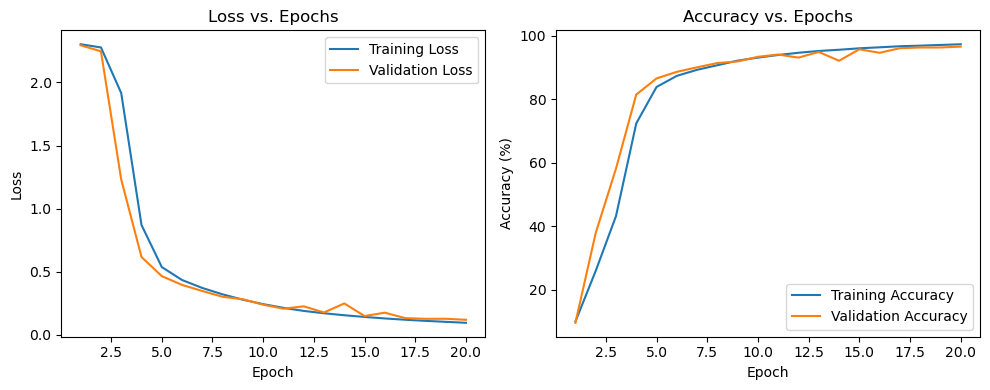

Training with layer configuration: [784, 512, 256, 128, 64, 32, 10]
Epoch 1, Train Loss: 2.3032, Val Loss: 2.3004, Train Acc: 10.78%, Val Acc: 11.65%
Epoch 2, Train Loss: 2.2986, Val Loss: 2.2966, Train Acc: 11.14%, Val Acc: 11.65%
Epoch 3, Train Loss: 2.2927, Val Loss: 2.2873, Train Acc: 11.14%, Val Acc: 11.78%
Epoch 4, Train Loss: 2.2707, Val Loss: 2.2401, Train Acc: 17.05%, Val Acc: 26.58%
Epoch 5, Train Loss: 1.9352, Val Loss: 1.2792, Train Acc: 37.97%, Val Acc: 53.03%
Epoch 6, Train Loss: 1.0216, Val Loss: 0.8606, Train Acc: 63.31%, Val Acc: 71.53%
Epoch 7, Train Loss: 0.7200, Val Loss: 0.7576, Train Acc: 78.10%, Val Acc: 74.94%
Epoch 8, Train Loss: 0.4846, Val Loss: 0.4155, Train Acc: 86.38%, Val Acc: 88.17%
Epoch 9, Train Loss: 0.3599, Val Loss: 0.3143, Train Acc: 89.81%, Val Acc: 91.03%
Epoch 10, Train Loss: 0.2828, Val Loss: 0.2902, Train Acc: 92.10%, Val Acc: 91.84%
Epoch 11, Train Loss: 0.2325, Val Loss: 0.3034, Train Acc: 93.62%, Val Acc: 90.77%
Epoch 12, Train Loss: 0.1940

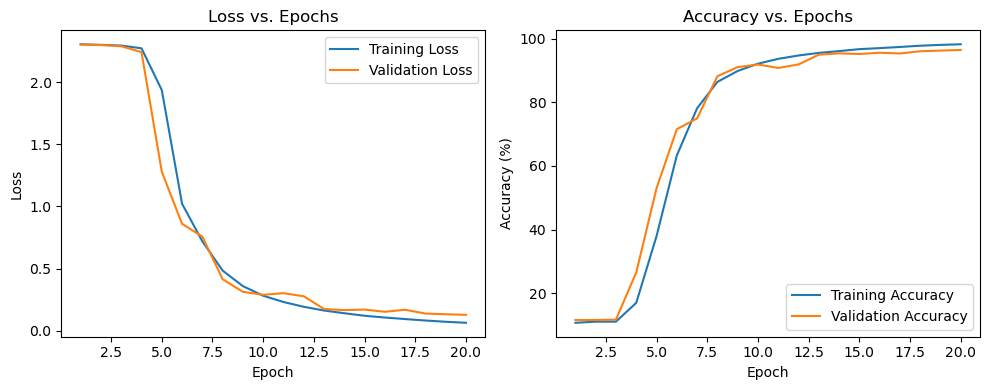


Best Layer Configuration: [784, 256, 128, 64, 32, 10] with Validation Accuracy: 96.57%



In [121]:
# try diff num of layers
criterion = nn.CrossEntropyLoss()
Epochs = 20
layer_nums = [
    [784, 128, 64, 10],       # 2 layers
    [784, 128, 64, 32, 10],   # 3 layers
    [784, 256, 128, 64, 32, 10],   # 4 layers
    [784, 512, 256, 128, 64, 32, 10]   # 5 layers
]
best_val_accuracy_layer = 0
best_layer_nums = None
print("Testing different layer configurations\n")
for layer in layer_nums:
    print(f"Training with layer configuration: {layer}")
    model = NeuralNetwork(layer)
    optimizer = optim.SGD(model.parameters(), lr=.01)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies)
    if max(val_accuracies) > best_val_accuracy_layer:
        best_val_accuracy_layer = max(val_accuracies)
        best_layer_nums = layer

print(f"\nBest Layer Configuration: {best_layer_nums} with Validation Accuracy: {best_val_accuracy_layer:.2f}%\n")



Testing random neuron configurations for the best number of hidden layers

Trial 1, Neuron Configuration: [784, 102, 237, 227, 79, 10]
Epoch 1, Train Loss: 2.2997, Val Loss: 2.2947, Train Acc: 11.60%, Val Acc: 13.69%
Epoch 2, Train Loss: 2.2721, Val Loss: 2.2134, Train Acc: 25.39%, Val Acc: 29.92%
Epoch 3, Train Loss: 1.7834, Val Loss: 1.2417, Train Acc: 41.40%, Val Acc: 61.83%
Epoch 4, Train Loss: 0.8144, Val Loss: 0.6190, Train Acc: 74.85%, Val Acc: 81.23%
Epoch 5, Train Loss: 0.5508, Val Loss: 0.5004, Train Acc: 83.87%, Val Acc: 85.17%
Epoch 6, Train Loss: 0.4524, Val Loss: 0.4146, Train Acc: 86.95%, Val Acc: 88.19%
Epoch 7, Train Loss: 0.3784, Val Loss: 0.3618, Train Acc: 89.17%, Val Acc: 89.61%
Epoch 8, Train Loss: 0.3211, Val Loss: 0.3309, Train Acc: 90.84%, Val Acc: 90.23%
Epoch 9, Train Loss: 0.2779, Val Loss: 0.2697, Train Acc: 92.05%, Val Acc: 92.26%
Epoch 10, Train Loss: 0.2455, Val Loss: 0.2535, Train Acc: 92.98%, Val Acc: 92.64%
Epoch 11, Train Loss: 0.2166, Val Loss: 0.2

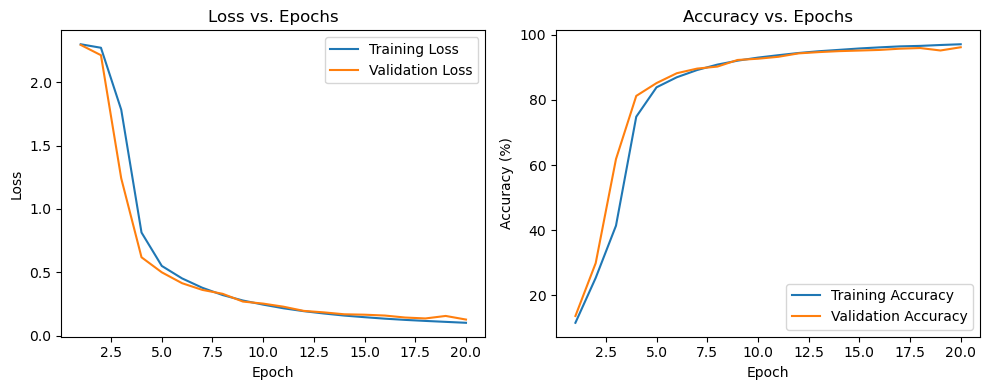

Validation Accuracy for Trial 1: 96.16%

Trial 2, Neuron Configuration: [784, 232, 116, 88, 136, 10]
Epoch 1, Train Loss: 2.2972, Val Loss: 2.2896, Train Acc: 11.67%, Val Acc: 11.65%
Epoch 2, Train Loss: 2.2605, Val Loss: 2.1830, Train Acc: 19.09%, Val Acc: 42.29%
Epoch 3, Train Loss: 1.6048, Val Loss: 0.9492, Train Acc: 52.04%, Val Acc: 65.47%
Epoch 4, Train Loss: 0.7074, Val Loss: 0.5824, Train Acc: 78.03%, Val Acc: 81.97%
Epoch 5, Train Loss: 0.5119, Val Loss: 0.4705, Train Acc: 85.12%, Val Acc: 86.38%
Epoch 6, Train Loss: 0.4129, Val Loss: 0.3799, Train Acc: 88.23%, Val Acc: 89.17%
Epoch 7, Train Loss: 0.3420, Val Loss: 0.3497, Train Acc: 90.34%, Val Acc: 89.47%
Epoch 8, Train Loss: 0.2923, Val Loss: 0.2791, Train Acc: 91.74%, Val Acc: 92.14%
Epoch 9, Train Loss: 0.2540, Val Loss: 0.2579, Train Acc: 92.80%, Val Acc: 92.71%
Epoch 10, Train Loss: 0.2236, Val Loss: 0.2242, Train Acc: 93.66%, Val Acc: 93.74%
Epoch 11, Train Loss: 0.1984, Val Loss: 0.2021, Train Acc: 94.39%, Val Acc: 94

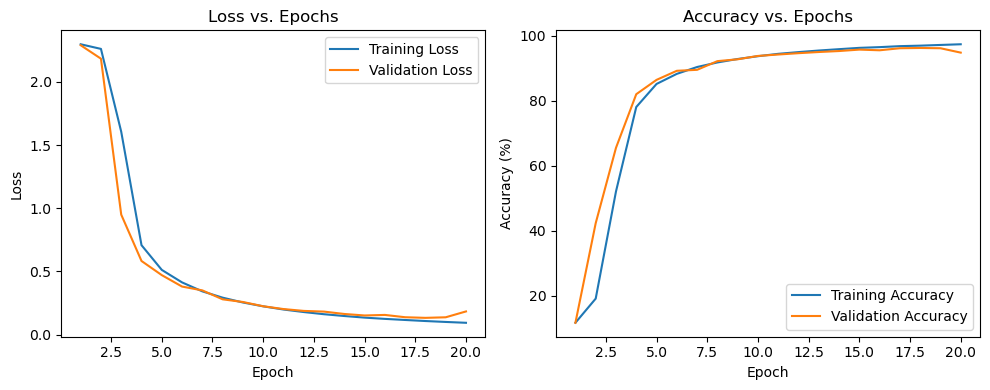

Validation Accuracy for Trial 2: 96.19%

Trial 3, Neuron Configuration: [784, 189, 64, 59, 239, 10]
Epoch 1, Train Loss: 2.2940, Val Loss: 2.2788, Train Acc: 12.94%, Val Acc: 18.25%
Epoch 2, Train Loss: 2.1684, Val Loss: 1.8694, Train Acc: 23.76%, Val Acc: 30.73%
Epoch 3, Train Loss: 1.1958, Val Loss: 0.7037, Train Acc: 61.59%, Val Acc: 78.12%
Epoch 4, Train Loss: 0.5759, Val Loss: 0.4836, Train Acc: 82.68%, Val Acc: 85.67%
Epoch 5, Train Loss: 0.4351, Val Loss: 0.3916, Train Acc: 87.31%, Val Acc: 88.85%
Epoch 6, Train Loss: 0.3608, Val Loss: 0.3297, Train Acc: 89.56%, Val Acc: 90.45%
Epoch 7, Train Loss: 0.3085, Val Loss: 0.3609, Train Acc: 91.11%, Val Acc: 89.00%
Epoch 8, Train Loss: 0.2676, Val Loss: 0.2525, Train Acc: 92.36%, Val Acc: 92.93%
Epoch 9, Train Loss: 0.2331, Val Loss: 0.2261, Train Acc: 93.31%, Val Acc: 93.73%
Epoch 10, Train Loss: 0.2060, Val Loss: 0.2061, Train Acc: 94.08%, Val Acc: 94.01%
Epoch 11, Train Loss: 0.1842, Val Loss: 0.1918, Train Acc: 94.67%, Val Acc: 94.

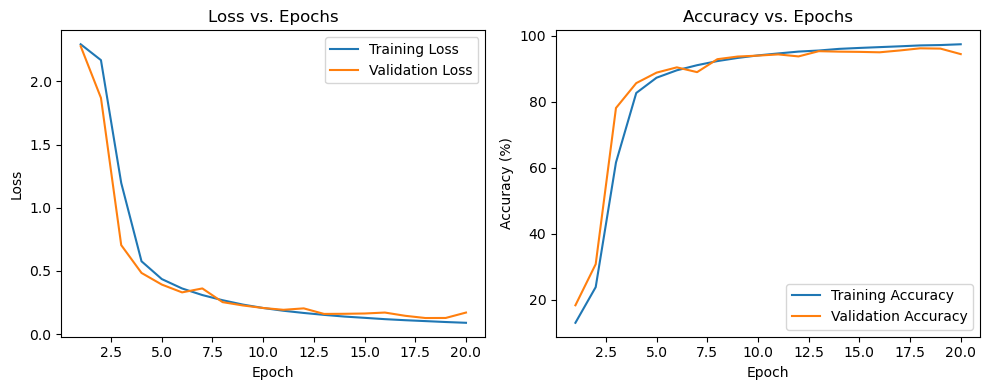

Validation Accuracy for Trial 3: 96.23%

Best Neuron Configuration: [784, 256, 128, 64, 32, 10] with Validation Accuracy: 96.57%


In [122]:
# try diff num of neurons
best_num_hidden_layers = len(best_layer_nums) - 2  # Exclude input (784) and output (10) layers
best_neuron = best_layer_nums
best_neuron_accuracy = best_val_accuracy_layer  # Replace with best validation accuracy from Stage 1
print("\nTesting random neuron configurations for the best number of hidden layers\n")
for trial in range(3):  # Try 3 random configurations + best of layers
    hidden_layers = [random.randint(32, 256) for _ in range(best_num_hidden_layers)]  
    neuron_config = [784] + hidden_layers + [10]  
    print(f"Trial {trial + 1}, Neuron Configuration: {neuron_config}")
    model = NeuralNetwork(neuron_config)  
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies)
    if max(val_accuracies) > best_neuron_accuracy:
        best_neuron_accuracy = max(val_accuracies)
        best_neuron = neuron_config
    print(f"Validation Accuracy for Trial {trial + 1}: {max(val_accuracies):.2f}%\n")
print(f"Best Neuron Configuration: {best_neuron} with Validation Accuracy: {best_neuron_accuracy:.2f}%")
model = NeuralNetwork(best_neuron)  
optimizer = optim.SGD(model.parameters(), lr=0.01)


0.001
Epoch 1, Train Loss: 2.3057, Val Loss: 2.3039, Train Acc: 8.93%, Val Acc: 9.02%
Epoch 2, Train Loss: 2.3039, Val Loss: 2.3022, Train Acc: 8.35%, Val Acc: 8.70%
Epoch 3, Train Loss: 2.3022, Val Loss: 2.3007, Train Acc: 8.49%, Val Acc: 9.41%
Epoch 4, Train Loss: 2.3006, Val Loss: 2.2993, Train Acc: 10.12%, Val Acc: 12.24%
Epoch 5, Train Loss: 2.2991, Val Loss: 2.2978, Train Acc: 14.46%, Val Acc: 18.88%
Epoch 6, Train Loss: 2.2975, Val Loss: 2.2964, Train Acc: 19.07%, Val Acc: 19.35%
Epoch 7, Train Loss: 2.2960, Val Loss: 2.2948, Train Acc: 18.51%, Val Acc: 19.67%
Epoch 8, Train Loss: 2.2943, Val Loss: 2.2932, Train Acc: 23.46%, Val Acc: 24.18%
Epoch 9, Train Loss: 2.2925, Val Loss: 2.2913, Train Acc: 22.23%, Val Acc: 19.58%
Epoch 10, Train Loss: 2.2904, Val Loss: 2.2893, Train Acc: 17.58%, Val Acc: 16.81%
Epoch 11, Train Loss: 2.2882, Val Loss: 2.2869, Train Acc: 16.54%, Val Acc: 17.03%
Epoch 12, Train Loss: 2.2856, Val Loss: 2.2842, Train Acc: 17.23%, Val Acc: 17.76%
Epoch 13, Tra

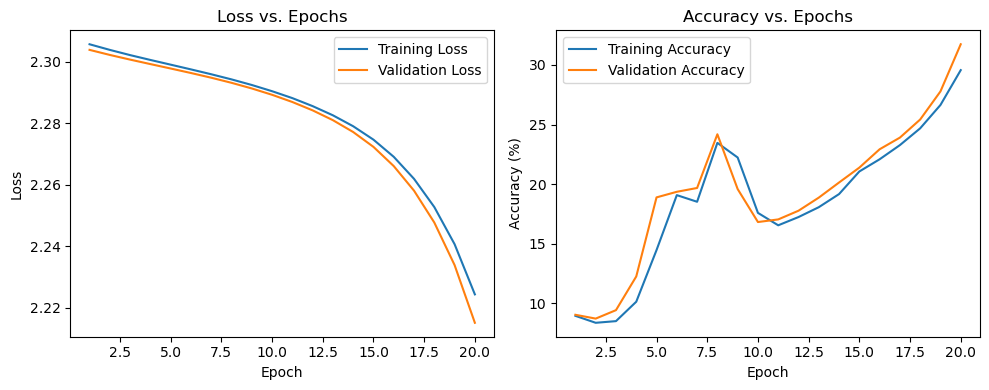

0.005
Epoch 1, Train Loss: 2.0900, Val Loss: 1.8488, Train Acc: 40.41%, Val Acc: 45.63%
Epoch 2, Train Loss: 1.3121, Val Loss: 0.8579, Train Acc: 62.23%, Val Acc: 73.62%
Epoch 3, Train Loss: 0.7279, Val Loss: 0.6451, Train Acc: 77.58%, Val Acc: 79.41%
Epoch 4, Train Loss: 0.6123, Val Loss: 0.5718, Train Acc: 81.41%, Val Acc: 82.75%
Epoch 5, Train Loss: 0.5508, Val Loss: 0.5369, Train Acc: 83.75%, Val Acc: 84.02%
Epoch 6, Train Loss: 0.5013, Val Loss: 0.4764, Train Acc: 85.43%, Val Acc: 86.18%
Epoch 7, Train Loss: 0.4545, Val Loss: 0.4316, Train Acc: 87.04%, Val Acc: 87.79%
Epoch 8, Train Loss: 0.4129, Val Loss: 0.4064, Train Acc: 88.22%, Val Acc: 88.19%
Epoch 9, Train Loss: 0.3743, Val Loss: 0.3545, Train Acc: 89.42%, Val Acc: 89.75%
Epoch 10, Train Loss: 0.3416, Val Loss: 0.3431, Train Acc: 90.41%, Val Acc: 89.72%
Epoch 11, Train Loss: 0.3110, Val Loss: 0.3024, Train Acc: 91.29%, Val Acc: 91.25%
Epoch 12, Train Loss: 0.2834, Val Loss: 0.2849, Train Acc: 92.03%, Val Acc: 91.72%
Epoch 1

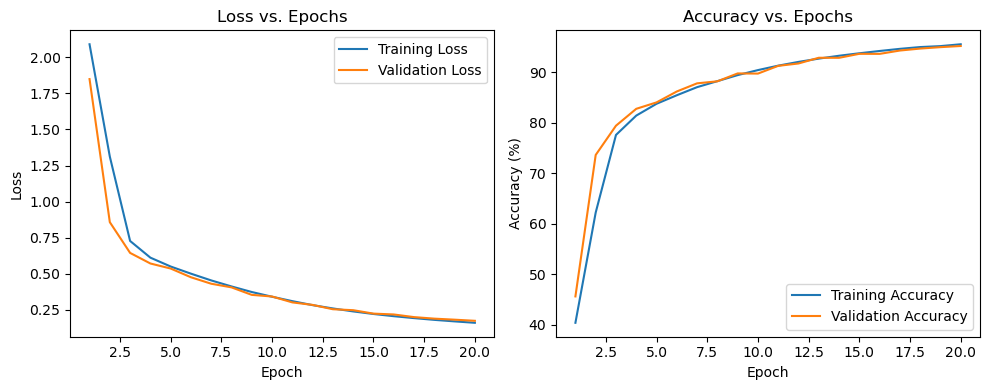

0.01
Epoch 1, Train Loss: 0.1568, Val Loss: 0.2082, Train Acc: 95.53%, Val Acc: 93.75%
Epoch 2, Train Loss: 0.1430, Val Loss: 0.1604, Train Acc: 95.97%, Val Acc: 95.44%
Epoch 3, Train Loss: 0.1302, Val Loss: 0.1421, Train Acc: 96.37%, Val Acc: 95.98%
Epoch 4, Train Loss: 0.1197, Val Loss: 0.1374, Train Acc: 96.64%, Val Acc: 96.02%
Epoch 5, Train Loss: 0.1112, Val Loss: 0.1541, Train Acc: 96.89%, Val Acc: 95.53%
Epoch 6, Train Loss: 0.1044, Val Loss: 0.1654, Train Acc: 97.08%, Val Acc: 95.05%
Epoch 7, Train Loss: 0.0964, Val Loss: 0.1664, Train Acc: 97.28%, Val Acc: 95.00%
Epoch 8, Train Loss: 0.0902, Val Loss: 0.1252, Train Acc: 97.45%, Val Acc: 96.17%
Epoch 9, Train Loss: 0.0832, Val Loss: 0.1176, Train Acc: 97.68%, Val Acc: 96.51%
Epoch 10, Train Loss: 0.0777, Val Loss: 0.1086, Train Acc: 97.82%, Val Acc: 96.63%
Epoch 11, Train Loss: 0.0718, Val Loss: 0.1101, Train Acc: 97.99%, Val Acc: 96.58%
Epoch 12, Train Loss: 0.0683, Val Loss: 0.1344, Train Acc: 98.16%, Val Acc: 96.07%
Epoch 13

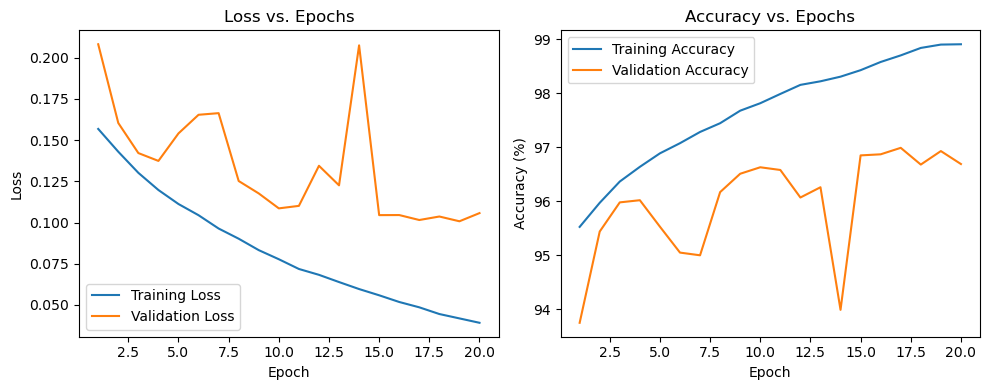

0.05
Epoch 1, Train Loss: 0.2689, Val Loss: 0.1254, Train Acc: 93.35%, Val Acc: 96.28%
Epoch 2, Train Loss: 0.0850, Val Loss: 0.1175, Train Acc: 97.49%, Val Acc: 96.50%
Epoch 3, Train Loss: 0.0621, Val Loss: 0.1136, Train Acc: 98.06%, Val Acc: 96.57%
Epoch 4, Train Loss: 0.0489, Val Loss: 0.1781, Train Acc: 98.47%, Val Acc: 94.81%
Epoch 5, Train Loss: 0.0417, Val Loss: 0.0888, Train Acc: 98.64%, Val Acc: 97.31%
Epoch 6, Train Loss: 0.0314, Val Loss: 0.0941, Train Acc: 99.06%, Val Acc: 97.32%
Epoch 7, Train Loss: 0.0262, Val Loss: 0.1466, Train Acc: 99.22%, Val Acc: 96.00%
Epoch 8, Train Loss: 0.0214, Val Loss: 0.0995, Train Acc: 99.34%, Val Acc: 97.26%
Epoch 9, Train Loss: 0.0201, Val Loss: 0.0936, Train Acc: 99.42%, Val Acc: 97.44%
Epoch 10, Train Loss: 0.0146, Val Loss: 0.0913, Train Acc: 99.57%, Val Acc: 97.65%
Epoch 11, Train Loss: 0.0114, Val Loss: 0.0887, Train Acc: 99.69%, Val Acc: 97.88%
Epoch 12, Train Loss: 0.0072, Val Loss: 0.0989, Train Acc: 99.82%, Val Acc: 97.53%
Epoch 13

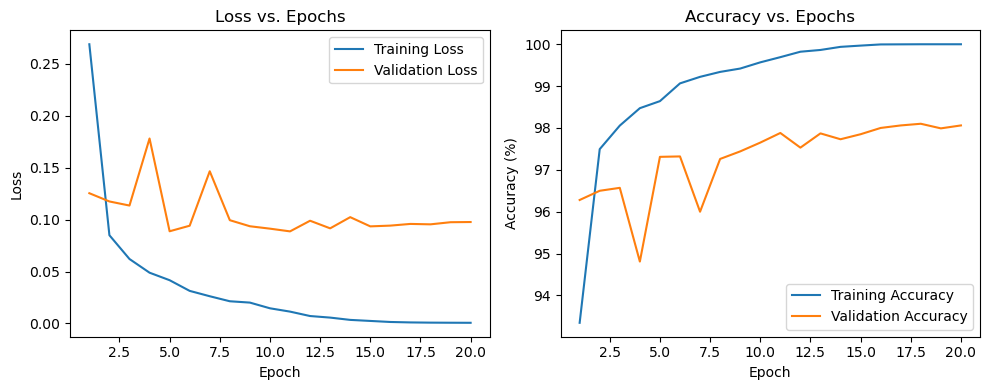


Best learning rate : 0.05 with Validation Accuracy: 98.10%



In [123]:
# try diff learning rate
max_accuracy = 0 
best_lr = 0 
learning_rate = [.001, .005, .01, .05] 
for i in range(0,4):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate[i])
    print(learning_rate[i])
    train_losses, val_losses, train_accuracies, val_accuracies_lr = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=Epochs)
    plot(list(range(1, Epochs + 1)),train_losses,val_losses,train_accuracies,val_accuracies_lr)
    if max(val_accuracies_lr) > max_accuracy:
        max_accuracy = max(val_accuracies_lr)
        best_lr = learning_rate[i]
optimizer = optim.SGD(model.parameters(), lr=best_lr)
print(f"\nBest learning rate : {best_lr} with Validation Accuracy: {max(val_accuracies_lr):.2f}%\n")

Training with batch size: 16
Epoch 1, Train Loss: 0.1361, Val Loss: 0.1325, Train Acc: 96.32%, Val Acc: 96.16%
Epoch 2, Train Loss: 0.0682, Val Loss: 0.0901, Train Acc: 97.86%, Val Acc: 97.52%
Epoch 3, Train Loss: 0.0450, Val Loss: 0.0844, Train Acc: 98.54%, Val Acc: 97.61%
Epoch 4, Train Loss: 0.0350, Val Loss: 0.1186, Train Acc: 98.85%, Val Acc: 97.10%
Epoch 5, Train Loss: 0.0303, Val Loss: 0.0928, Train Acc: 99.04%, Val Acc: 97.65%
Epoch 6, Train Loss: 0.0221, Val Loss: 0.0914, Train Acc: 99.32%, Val Acc: 97.78%
Epoch 7, Train Loss: 0.0216, Val Loss: 0.0840, Train Acc: 99.30%, Val Acc: 97.82%
Epoch 8, Train Loss: 0.0158, Val Loss: 0.0945, Train Acc: 99.47%, Val Acc: 97.93%
Epoch 9, Train Loss: 0.0163, Val Loss: 0.1189, Train Acc: 99.44%, Val Acc: 97.26%
Epoch 10, Train Loss: 0.0147, Val Loss: 0.0935, Train Acc: 99.55%, Val Acc: 97.94%
Epoch 11, Train Loss: 0.0115, Val Loss: 0.1043, Train Acc: 99.63%, Val Acc: 97.72%
Epoch 12, Train Loss: 0.0083, Val Loss: 0.0987, Train Acc: 99.74%, 

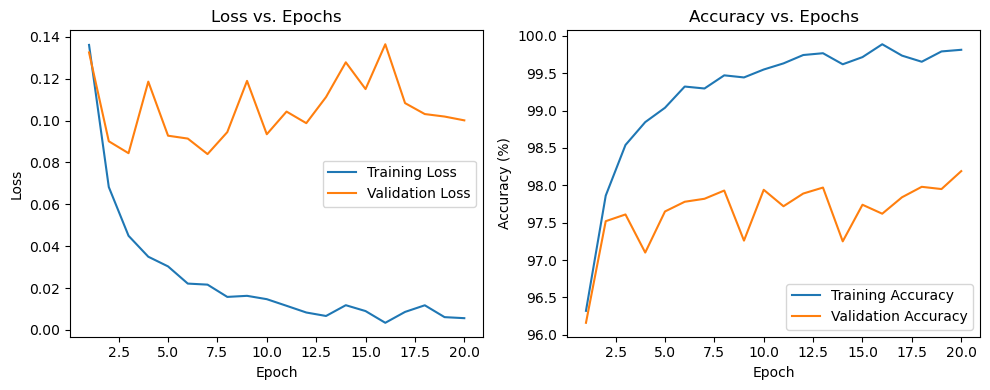

Training with batch size: 32
Epoch 1, Train Loss: 0.0012, Val Loss: 0.0937, Train Acc: 99.97%, Val Acc: 98.38%
Epoch 2, Train Loss: 0.0003, Val Loss: 0.0948, Train Acc: 100.00%, Val Acc: 98.40%
Epoch 3, Train Loss: 0.0002, Val Loss: 0.0958, Train Acc: 100.00%, Val Acc: 98.42%
Epoch 4, Train Loss: 0.0002, Val Loss: 0.0969, Train Acc: 100.00%, Val Acc: 98.40%
Epoch 5, Train Loss: 0.0002, Val Loss: 0.0980, Train Acc: 100.00%, Val Acc: 98.40%
Epoch 6, Train Loss: 0.0002, Val Loss: 0.0990, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 7, Train Loss: 0.0001, Val Loss: 0.0996, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 8, Train Loss: 0.0001, Val Loss: 0.1004, Train Acc: 100.00%, Val Acc: 98.34%
Epoch 9, Train Loss: 0.0001, Val Loss: 0.1012, Train Acc: 100.00%, Val Acc: 98.36%
Epoch 10, Train Loss: 0.0001, Val Loss: 0.1018, Train Acc: 100.00%, Val Acc: 98.36%
Epoch 11, Train Loss: 0.0001, Val Loss: 0.1024, Train Acc: 100.00%, Val Acc: 98.36%
Epoch 12, Train Loss: 0.0001, Val Loss: 0.1029, Train Acc

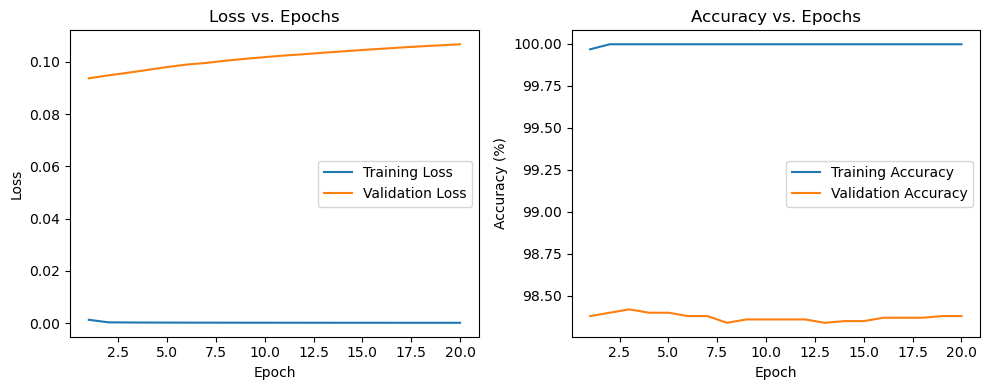

Training with batch size: 48
Epoch 1, Train Loss: 0.0001, Val Loss: 0.1069, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 2, Train Loss: 0.0001, Val Loss: 0.1071, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 3, Train Loss: 0.0001, Val Loss: 0.1074, Train Acc: 100.00%, Val Acc: 98.36%
Epoch 4, Train Loss: 0.0001, Val Loss: 0.1076, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 5, Train Loss: 0.0001, Val Loss: 0.1077, Train Acc: 100.00%, Val Acc: 98.37%
Epoch 6, Train Loss: 0.0001, Val Loss: 0.1080, Train Acc: 100.00%, Val Acc: 98.37%
Epoch 7, Train Loss: 0.0001, Val Loss: 0.1082, Train Acc: 100.00%, Val Acc: 98.36%
Epoch 8, Train Loss: 0.0001, Val Loss: 0.1085, Train Acc: 100.00%, Val Acc: 98.37%
Epoch 9, Train Loss: 0.0001, Val Loss: 0.1087, Train Acc: 100.00%, Val Acc: 98.37%
Epoch 10, Train Loss: 0.0001, Val Loss: 0.1089, Train Acc: 100.00%, Val Acc: 98.36%
Epoch 11, Train Loss: 0.0001, Val Loss: 0.1091, Train Acc: 100.00%, Val Acc: 98.37%
Epoch 12, Train Loss: 0.0001, Val Loss: 0.1092, Train Ac

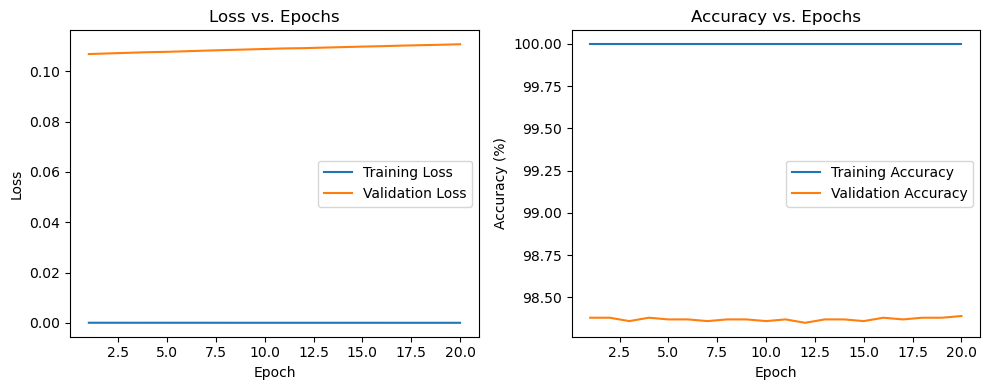

Training with batch size: 64
Epoch 1, Train Loss: 0.0001, Val Loss: 0.1107, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 2, Train Loss: 0.0001, Val Loss: 0.1108, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 3, Train Loss: 0.0001, Val Loss: 0.1110, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 4, Train Loss: 0.0001, Val Loss: 0.1111, Train Acc: 100.00%, Val Acc: 98.39%
Epoch 5, Train Loss: 0.0001, Val Loss: 0.1112, Train Acc: 100.00%, Val Acc: 98.39%
Epoch 6, Train Loss: 0.0001, Val Loss: 0.1113, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 7, Train Loss: 0.0001, Val Loss: 0.1115, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 8, Train Loss: 0.0001, Val Loss: 0.1116, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 9, Train Loss: 0.0001, Val Loss: 0.1117, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 10, Train Loss: 0.0001, Val Loss: 0.1118, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 11, Train Loss: 0.0001, Val Loss: 0.1119, Train Acc: 100.00%, Val Acc: 98.38%
Epoch 12, Train Loss: 0.0001, Val Loss: 0.1121, Train Ac

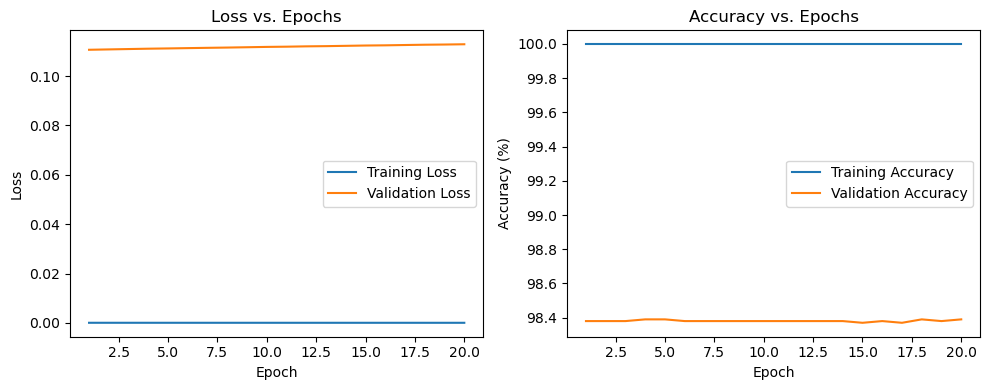


Best batch size: 32 with Validation Accuracy: 98.42%


In [124]:
# try diff batch size
batch_size_list = [16, 32, 48, 64] 
max_accuracy = 0
best_batch = None
train_size = 50000
val_size = 10000
test_size = 10000
for batch_size in batch_size_list:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"Training with batch size: {batch_size}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=Epochs
    )
    plot(list(range(1, Epochs + 1)), train_losses, val_losses, train_accuracies, val_accuracies)
    highest_val_accuracy = max(val_accuracies) 
    if highest_val_accuracy > max_accuracy:
        max_accuracy = highest_val_accuracy
        best_batch = batch_size

print(f"\nBest batch size: {best_batch} with Validation Accuracy: {max_accuracy:.2f}%")
# Final training with the best batch size
# train_loader = DataLoader(train_dataset, batch_size=best_batch, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=best_batch, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=best_batch, shuffle=False)


In [125]:
# In the next cell we will define the loss function (cross-entropy), and optimizer (stochastic gradient descend).
# model = NeuralNetwork()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

### Analysis
in the following cells we will plot diagrams to analyse the model. The very next cell plots the training and validation loss.

In the next cell we will test the model on the test data and plot the acuuracy as epochs increase.

Test Loss: 0.1307, Test Accuracy: 98.21%
best learning rate:0.05, best batch:32, 
best number of layers:[784, 256, 128, 64, 32, 10], best nurons:[784, 256, 128, 64, 32, 10] 


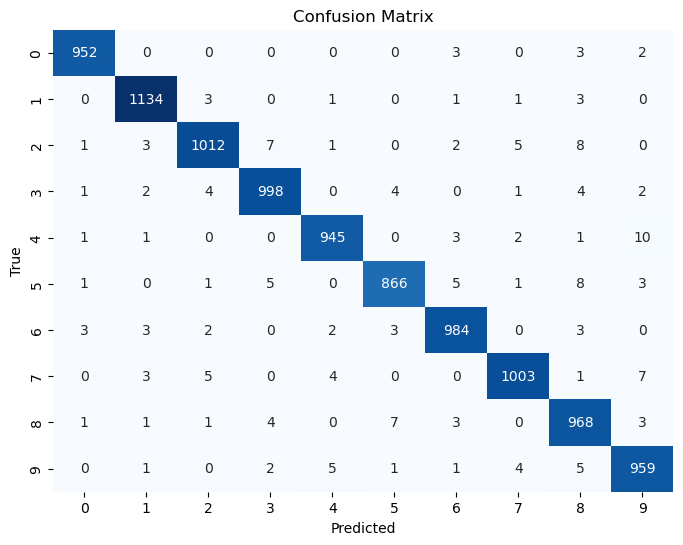

In [126]:
# test 
def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    test_correct = 0
    total_test = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            # Ensure images are in the correct shape (batch_size, channels, height, width)
            images = images.view(images.size(0), 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            test_loss += loss.item()  # Accumulate loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total_test += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Store the labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * test_correct / total_test

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    print(f"best learning rate:{best_lr}, best batch:{best_batch}, \nbest number of layers:{best_layer_nums}, best nurons:{best_neuron} ")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plot_confusion_matrix(cm)

    return avg_loss, accuracy

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the test_model function
test_loss, test_accuracy = test_model(model, test_loader, criterion)



torch.Size([64, 784]) torch.Size([64])


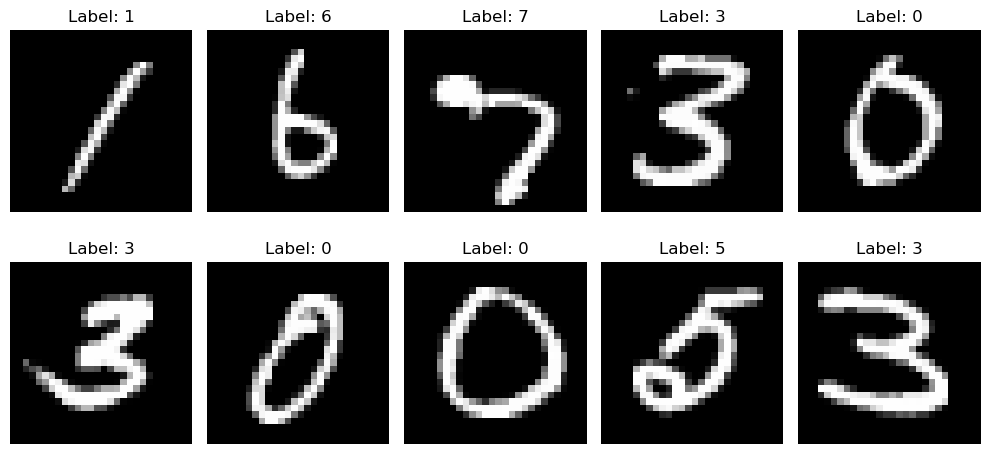

In [127]:
# Get a batch of test data
examples = iter(test_loader)  # Replace train_loader with test_loader
samples, labels = next(examples)  # Use next() to get the next batch
# Print the shape of the sample and labels
print(samples.shape, labels.shape)
# Create a 2x5 grid to display 10 images
plt.figure(figsize=(10, 5))  # Set the size of the figure
# Loop through the first 10 samples and plot them
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns, index starts from 1
    plt.imshow(samples[i].view(28, 28).cpu().numpy(), cmap='gray')  # Reshape the image to 28x28
    plt.title(f"Label: {labels[i].item()}")  # Display the corresponding label
    plt.axis('off')  # Hide the axes for a cleaner look
# Show the plot
plt.tight_layout()
plt.show()


#### insights

chosing good learning rate has a big affect on the performance so we must chose suitable one so don't chose it too low as it will be slow to improve and Too high can make it unstable.

bitch size mustn't be small to decrease error percent with every update for Gradient descent as Smaller batches are noisier but quicker to adjust; larger batches are more stable but slower.

different number of layers and changing number of neurons has a large influence on the performance of the model and more layers and neurons help the model learn complex patterns, but too many can cause overfitting.

In [128]:
def trainCnn_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    TrainLoss = []
    ValLoss = []
    TrainAcc = []
    ValAcc = []
    for epoch in range(epochs):
        train_loss = 0
        train_correct = 0
        total_train = 0
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images.view(images.size(0), 1, 28, 28))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * train_correct / total_train
        TrainAcc.append(train_accuracy)

        val_loss = 0
        val_correct = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images.view(images.size(0), 1, 28, 28))
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / total_val
        ValAcc.append(val_accuracy)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        TrainLoss.append(train_loss/len(train_loader))
        ValLoss.append(val_loss/len(val_loader))
        
    return TrainLoss, ValLoss, TrainAcc, ValAcc
    


Training CNN model
Epoch 1, Train Loss: 2.1724, Val Loss: 1.4222, Train Acc: 22.46%, Val Acc: 62.60%
Epoch 2, Train Loss: 1.0390, Val Loss: 0.4941, Train Acc: 64.61%, Val Acc: 85.55%
Epoch 3, Train Loss: 0.6543, Val Loss: 0.3287, Train Acc: 79.08%, Val Acc: 90.31%
Epoch 4, Train Loss: 0.5155, Val Loss: 0.2668, Train Acc: 84.32%, Val Acc: 91.98%
Epoch 5, Train Loss: 0.4370, Val Loss: 0.2125, Train Acc: 86.92%, Val Acc: 93.52%
Epoch 6, Train Loss: 0.3655, Val Loss: 0.1779, Train Acc: 89.35%, Val Acc: 94.63%
Epoch 7, Train Loss: 0.3176, Val Loss: 0.1570, Train Acc: 90.86%, Val Acc: 95.19%
Epoch 8, Train Loss: 0.2740, Val Loss: 0.1306, Train Acc: 92.26%, Val Acc: 96.11%
Epoch 9, Train Loss: 0.2419, Val Loss: 0.1237, Train Acc: 93.20%, Val Acc: 96.40%
Epoch 10, Train Loss: 0.2201, Val Loss: 0.1030, Train Acc: 93.87%, Val Acc: 96.89%
Epoch 11, Train Loss: 0.1997, Val Loss: 0.1030, Train Acc: 94.43%, Val Acc: 97.01%
Epoch 12, Train Loss: 0.1859, Val Loss: 0.0905, Train Acc: 94.89%, Val Acc: 9

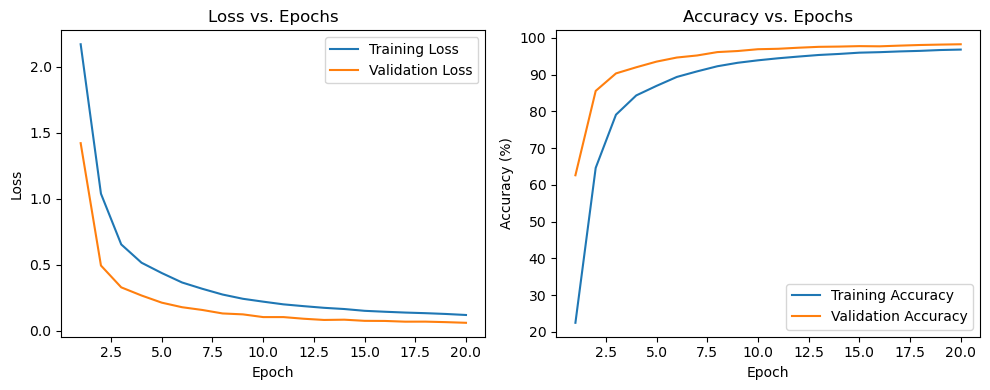

Training NN model
Epoch 1, Train Loss: 2.3012, Val Loss: 2.2914, Train Acc: 12.81%, Val Acc: 31.48%
Epoch 2, Train Loss: 2.2569, Val Loss: 2.1624, Train Acc: 29.82%, Val Acc: 29.56%
Epoch 3, Train Loss: 1.7960, Val Loss: 1.2489, Train Acc: 42.76%, Val Acc: 61.09%
Epoch 4, Train Loss: 0.8500, Val Loss: 0.6377, Train Acc: 72.93%, Val Acc: 79.49%
Epoch 5, Train Loss: 0.5506, Val Loss: 0.4976, Train Acc: 83.59%, Val Acc: 85.30%
Epoch 6, Train Loss: 0.4329, Val Loss: 0.3858, Train Acc: 87.55%, Val Acc: 88.87%
Epoch 7, Train Loss: 0.3604, Val Loss: 0.3323, Train Acc: 89.65%, Val Acc: 90.53%
Epoch 8, Train Loss: 0.3100, Val Loss: 0.2926, Train Acc: 91.17%, Val Acc: 91.52%
Epoch 9, Train Loss: 0.2698, Val Loss: 0.2552, Train Acc: 92.21%, Val Acc: 92.59%
Epoch 10, Train Loss: 0.2379, Val Loss: 0.2343, Train Acc: 93.19%, Val Acc: 92.99%
Epoch 11, Train Loss: 0.2121, Val Loss: 0.2067, Train Acc: 93.97%, Val Acc: 94.08%
Epoch 12, Train Loss: 0.1912, Val Loss: 0.2135, Train Acc: 94.64%, Val Acc: 93

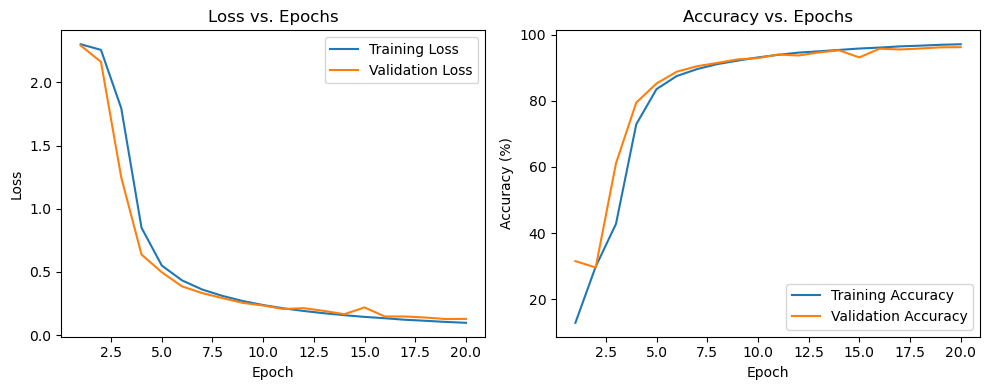

CNN Validation Accuracy: 98.24%
NN Validation Accuracy: 96.30%


In [ ]:
# Define the CNN model
cnn_model = CNN(layer_size=[64*7*7, 128, 64, 10])
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)

# Train the CNN model
print("Training CNN model")
cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = trainCnn_model(
    cnn_model, train_loader, val_loader, criterion, cnn_optimizer, epochs=Epochs
)

# Plot the training and validation loss and accuracy for CNN
plot(list(range(1, Epochs + 1)), cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies)

# Define the NN model
nn_model = NeuralNetwork(best_neuron)
nn_optimizer = optim.SGD(nn_model.parameters(), lr=0.01)

# Train the NN model
print("Training NN model")
nn_train_losses, nn_val_losses, nn_train_accuracies, nn_val_accuracies = train_model(
    nn_model, train_loader, val_loader, criterion, nn_optimizer, epochs=Epochs
)

# Plot the training and validation loss and accuracy for NN
plot(list(range(1, Epochs + 1)), nn_train_losses, nn_val_losses, nn_train_accuracies, nn_val_accuracies)

# Compare the performance
print(f"CNN Validation Accuracy: {max(cnn_val_accuracies):.2f}%")
print(f"NN Validation Accuracy: {max(nn_val_accuracies):.2f}%")